resources:
- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
- https://domino.ai/blog/fitting-gaussian-process-models-python
- https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
- https://www.cs.toronto.edu/~duvenaud/cookbook/

In [1]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import pickle
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    mean_absolute_error,
)
import numpy as np
import seaborn as sns
import matplotlib

# 1D

In [132]:
points = get_points('../data/artificial_points_gp.csv')

points = points[points.lat == 0]

points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lon']].values
y = points['wait'].values

# assuming mean = 0 in the gp setup
average = np.mean(y)

test_start = 1000000
test_stop = 2600000

In [147]:
# manual noise
# lets say for 5 min we want 95% confidence interval to lie between 0 and 10 min -> stdv = 2.5
# for 3 h we want 95% confidence interval to lie between 2.5 and 3.5 h -> stdv = 15.0

# see for improvement
# https://pubmed.ncbi.nlm.nih.gov/33083992/
# http://www.bccn-munich.de/research/bernstein-ii/individual-projects/project-b-t5-understanding-the-effects-of-temporal-context-on-interval-timing-a-model-based-approach
def noise_from_waiting_time(wait):
    return 0.025 * wait + 2.355 # new
    return 0.071 * wait + 2.145

v_noise_from_waiting_time = np.vectorize(noise_from_waiting_time)


In [148]:
points = get_points('../data/points_train.csv')
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)

points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

vertical_cut = 6621293 # cutting Germany vertically through Dresden
offset = 10000 # 10km strip
points = points[(points.lat > vertical_cut - offset) & (points.lat < vertical_cut + offset)]

X = points[['lon']].values
y = points['wait'].values

noise_per_datapoint = v_noise_from_waiting_time(y)
noise_per_datapoint = np.log(noise_per_datapoint)

# assuming mean = 0 in the gp setup
y_ = np.log(y)

average = np.mean(y_)
y_ = y_ - average
stdv = np.std(y_)

# ->
test_start = 0.4e6
test_stop = 1.7e6

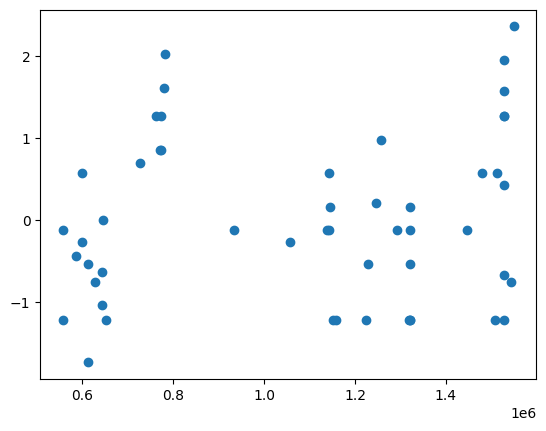

In [149]:
plt.scatter(X, y_, label="Observations")

<ErrorbarContainer object of 3 artists>

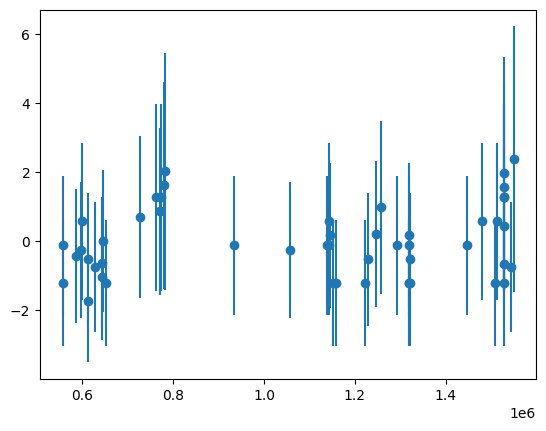

In [150]:
# 95% confidence interval
plt.errorbar(X, y_, yerr=noise_per_datapoint * 2, fmt="o", capsize=0)

## fixed parameters

In [151]:
l = 5e4
sigma = stdv

# setting kernel bounds to 'fixed' to prevent them from being fitted
rbf = RBF(length_scale=l, length_scale_bounds='fixed')
kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds='fixed') * rbf

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y_)
gp.kernel_, np.exp(gp.kernel_.theta)

(1.01**2 * RBF(length_scale=5e+04), array([], dtype=float64))

Text(0, 0.5, '$f(x)$')

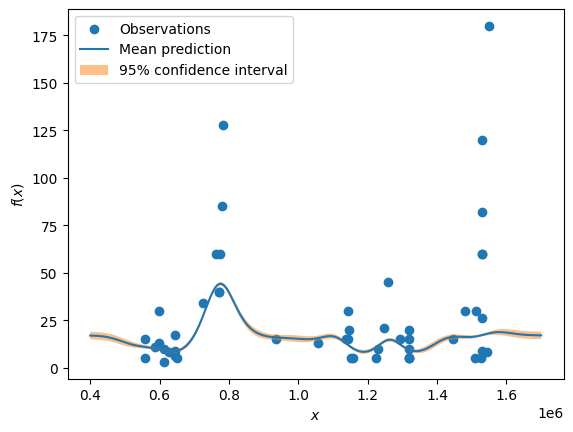

In [152]:
x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

y_pred, std_prediction = gp.predict(x_test, return_std=True)
y_pred = np.exp(y_pred + average) # add back the mean

plt.scatter(X, y, label="Observations")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - 1.96 * std_prediction,
    y_pred + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

## optimize parameters

In [153]:
# larger rbf sigma (stdv) to allow deviation from 0 (mean) -> factor before rbf kernel via constant kernel -> sigma
# larger rbf length scale for more smoothness; assume "no" influence beyond length scale -> length scale of rbf kernel -> l

# error (noise) stdv added to diagonal of kernel matrix as parameter -> alpha

# parameters to optimize
sigma = 10.0
sigma_bounds = (1e-1,1e7) # unit are minutes

l = 1e6  # only lon dimensions; set starting value to 1000km
length_scale_bounds = (5e4, 1e7) # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 0.0 # as WhiteKernel is used to optimized noise

noise_level = 1.0
noise_level_bounds = (1e-1,1e1)  # unit are minutes

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)

kernel = ConstantKernel(
    constant_value=sigma, constant_value_bounds=sigma_bounds
) * rbf # + WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=1000,
    random_state=42,
)

# try adujusting the mean to 0 vs. setting normalize_y to True (this is not preferred as it also standardizes which results in less intuitive kernel parameters)
# setting noise per datapoint with more noise on larger values

# WhiteKernel can be used instead of alpha to optimize noise (per datapoint) as well -> set alpha to 0
# set WhiteKernel bounds narrow to not overfit noise (everything is explained by noise)

In [154]:
gp.fit(X, y - average)

  5%|▍         | 49/1000 [00:00<00:01, 481.77it/s]

100%|██████████| 1000/1000 [00:02<00:00, 433.57it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 50000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=array([1.28372008, 1.10055173, 1.21061073, 0.78835088, 0.82493361,
       0.82493361, 1.00862172, 0.82493361, 1.82080211, 0.91667733,
       2.81578704, 1.82080211, 0.82493361, 0.91667733, 3.70554151,
       1.55508954, 1.46519349, 1.00862172, 2.94019068, 1.28372008,
       0.8432542 , 0.89218263, 1.00862172, 0.93505776, 1.28372008,
       1.35655425, 0.87994197, 1.0454059 , 1.00862172, 1.00862172,
       1.82080211, 1.10055173, 2.24886928, 1.00862172, 0.97183475,
       0.82493361, 0.91667733, 0.82493361, 0.82493361, 1.11892031,
       0.97183475, 1.46519349, 1.28372008, 2.19851868, 0.89830474,
       1.00862172, 0.87994197, 1.82080211, 0.82493361, 0.82493361,
       0.82493361]),
                         kernel=3.16**2 * RBF(length_scale=1e+06),
                         n_restarts_optimizer=1000, random_state=42)

In [155]:
gp.kernel_, np.exp(gp.kernel_.theta)
# note that length_scale and noise_level take the values at the bounds of the allowed range (indicator that this is not a local optimum)

(3.16e+03**2 * RBF(length_scale=5e+04),
 array([10000000.00000001,    50000.        ]))

In [156]:
x_test = np.linspace(start=test_start, stop=test_stop, num=300)
x_test = np.array([[xi] for xi in x_test])

In [157]:
y_pred, std_prediction = gp.predict(x_test, return_std=True)
y_pred = y_pred + average # add back the mean

Text(0, 0.5, '$f(x)$')

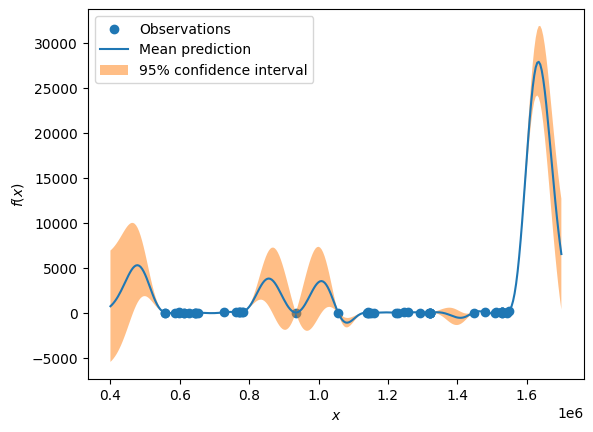

In [158]:
plt.scatter(X, y, label="Observations")
plt.plot(x_test, y_pred, label="Mean prediction")
plt.fill_between(
    x_test.ravel(),
    y_pred - 1.96 * std_prediction,
    y_pred + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [159]:
# TODO: constraining so that predictions cannot drop below 0 (wait time cannot be negative)
# TODO: prevent getting hyperparameters at interval bounds

## hyperparam search

In [160]:
from matplotlib.colors import LogNorm

length_scale = np.logspace(4, 7, num=50)
noise_level = np.logspace(-2, 2, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

ValueError: theta has not the correct number of entries. Should be 1; given are 2

ValueError: Contour levels must be increasing

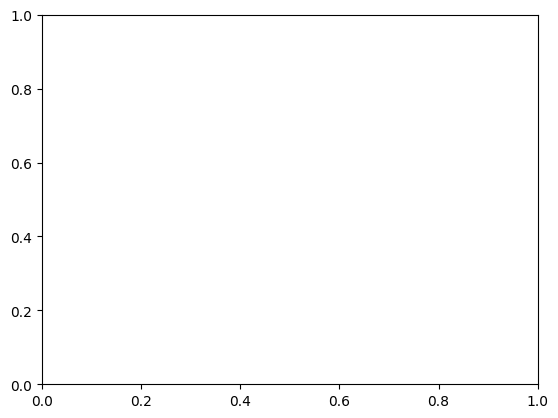

In [ ]:
vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax),
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

In [ ]:
# plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
# plt.plot(x, y, "ro")

In [ ]:


# Root mean squared error ... for eval

In [ ]:
stop

NameError: name 'stop' is not defined

# 2D using location

In [ ]:
points = get_points('../data/points_train.csv')
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

noise_per_datapoint = v_noise_from_waiting_time(y)

average = np.mean(y)
stdv = np.std(y)

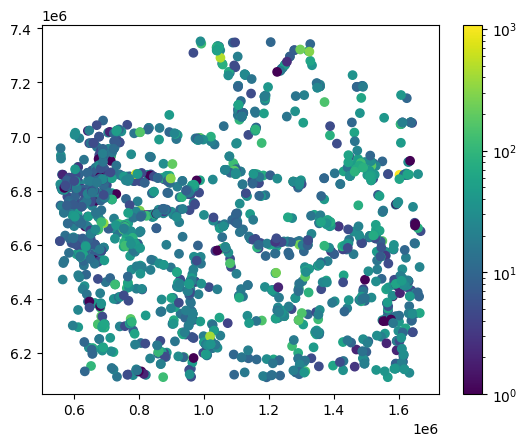

In [ ]:
plt.scatter(X[:,1], X[:,0], c=y, norm='log', label="Observations")
plt.colorbar()

## fixed params


In [ ]:
# parameters to optimize
l = 9e4
L = [l, l]
sigma = stdv

rbf = RBF(
    length_scale=L, length_scale_bounds="fixed"
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(constant_value=sigma**2, constant_value_bounds="fixed") * rbf

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=noise_per_datapoint**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=0,
    random_state=42,
)

gp.fit(X, y - average)
gp.kernel_, np.exp(gp.kernel_.theta)

(49.7**2 * RBF(length_scale=[9e+04, 9e+04]), array([], dtype=float64))

In [ ]:
# draw map

X, Y = get_map_grid(polygon, map_boundary, 10)
grid = np.array((Y, X)).T
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

100%|██████████| 100/100 [00:01<00:00, 52.43it/s]


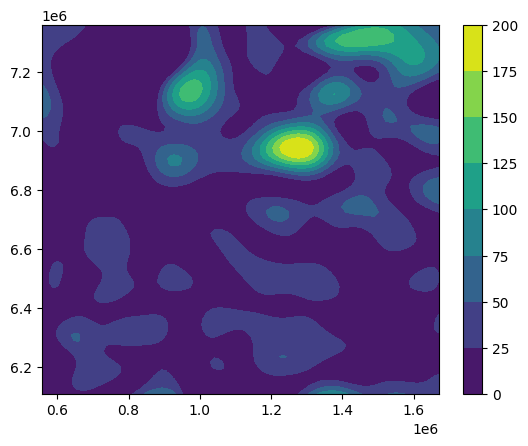

In [ ]:
map = np.clip(map, 0, 200)
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

## optimize params

In [ ]:
# parameters to optimize
sigma = 10.0
sigma_bounds = (1e-1,1e2) # unit are minutes

l = [1e6, 1e6]  # only lon dimensions; set starting value to 1000km
length_scale_bounds = (1e5, 1e7) # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 0.0 # as WhiteKernel is used to optimized noise

noise_level = 1.0
noise_level_bounds = (1e-1,1e1)  # unit are minutes

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)  # using anisotripic kernel (different length scales for each dimension)

kernel = ConstantKernel(
    constant_value=sigma, constant_value_bounds=sigma_bounds
) * rbf + WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=alpha**2,
    optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=1000,
    random_state=42,
)

In [ ]:
# europe: 2 min/ optimization run
gp.fit(X, y - average)

with open('models/gp_model.pkl', 'wb') as f:
    pickle.dump(gp, f)

  1%|          | 6/1000 [06:37<18:18:09, 66.29s/it]

In [ ]:
gp = pickle.load(open('models/europe.pkl', 'rb'))

In [ ]:
gp.kernel_, np.exp(gp.kernel_.theta)

(10**2 * RBF(length_scale=[1e+05, 1e+05]) + WhiteKernel(noise_level=10),
 array([1.e+02, 1.e+05, 1.e+05, 1.e+01]))

In [ ]:
# training error
points["pred"], points["std"] = gp.predict(X, return_std=True)#
points["pred"] = points["pred"] + average

(mean_squared_error(points["wait"], points["pred"]), 
root_mean_squared_error(points["wait"], points["pred"]),
mean_absolute_error(points["wait"], points["pred"]))

(3074.3460776484976, 55.44678599926688, 26.43591843450959)

In [ ]:
# validation error
val = get_points('../data/points_val.csv')
val, polygon, map_boundary = get_points_in_region(val, region)
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X = val[['lat', 'lon']].values
val['pred'], val['std'] = gp.predict(X, return_std=True)
val['pred'] = val['pred'] + average

(mean_squared_error(val['wait'], val['pred']),
root_mean_squared_error(val['wait'], val['pred']),
mean_absolute_error(val['wait'], val['pred']))

(3901.108315033012, 62.45885297564319, 31.302104215328182)

In [ ]:
# draw map

X, Y = get_map_grid(polygon, map_boundary, 10)
grid = np.array((Y, X)).T

In [ ]:
map = np.empty((0, X.shape[0]))
certainty_map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred + average))
    certainty_map = np.vstack((certainty_map, stdv))

map = map.T
certainty_map = certainty_map.T

100%|██████████| 570/570 [07:28<00:00,  1.27it/s]


In [ ]:
np.savetxt(f'intermediate/map_gp_{region}.txt', map)

In [ ]:
map = np.clip(map, 0, 120)

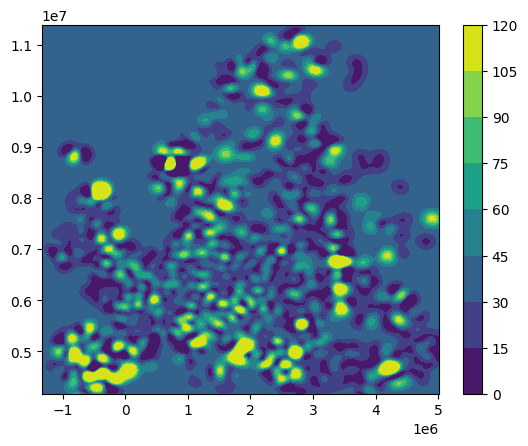

In [ ]:
plt.contourf(X, Y, map)
plt.colorbar()
plt.show()

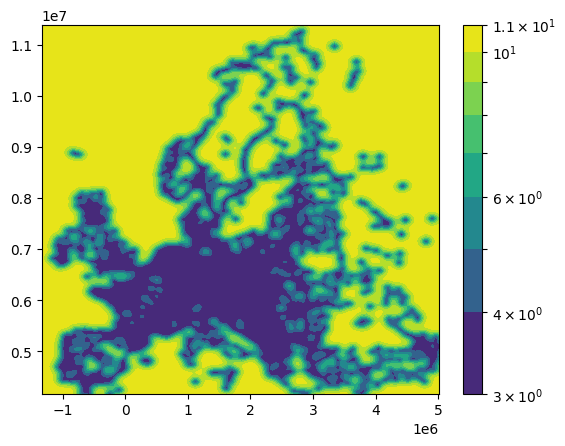

In [ ]:
plt.contourf(X, Y, certainty_map, norm='log')
plt.colorbar()
plt.show()

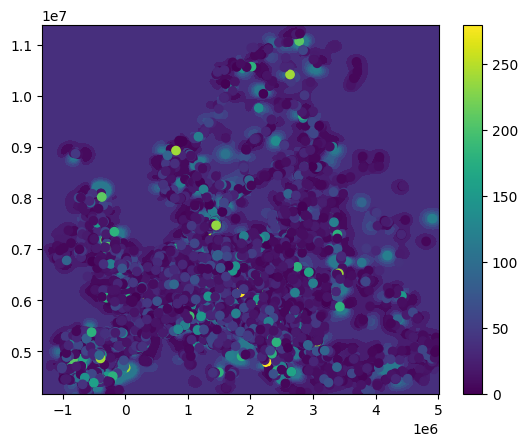

In [ ]:
# preview

plot_points = points[points.wait < 300]
mi = np.min((plot_points.wait.min(), map.min()))
ma = np.max((plot_points.wait.max(), map.max()))
norm = matplotlib.colors.Normalize(vmin=mi,vmax=ma)

plt.contourf(X, Y, map, norm=norm)
plt.scatter(plot_points.lon, plot_points.lat, c=plot_points.wait, norm=norm, label="Observations")
plt.colorbar()
plt.show()

## experiment: does adding more data lead to a descrease of length scale?

In [ ]:
points = get_points("../data/points_train.csv")
region = "germany"
points, polygon, map_boundary = get_points_in_region(points, region)
points["lat"] = points.geometry.y
points["lon"] = points.geometry.x

# split points into 10 splits
num_splits = 10
from numpy.random import RandomState

random = RandomState(42)
points["split"] = random.randint(0, num_splits, points.shape[0])

# parameters to optimize
sigma = 60
sigma_bounds = (60, 60)  # unit are minutes

l = [1e6, 1e6]  # only lon dimensions; set starting value to 1000km
length_scale_bounds = (
    1e1,
    1e7,
)  # from the scatter plot above; in the metirc crs this implies influence between 10km and 10000km

alpha = 5.0  # as WhiteKernel is used to optimized noise

rbf = RBF(
    length_scale=l, length_scale_bounds=length_scale_bounds
)  # using anisotripic kernel (different length scales for each dimension)

kernel = (
    ConstantKernel(constant_value=sigma**2, constant_value_bounds=np.power(sigma_bounds,2)) * rbf
)

for split in range(num_splits):

    p = points[points.split <= split]

    X = p[["lat", "lon"]].values
    y = p["wait"].values
    print(X.shape)

    average = np.mean(y)

    gp = GaussianProcessRegressor(
        kernel=kernel,
        alpha=alpha**2,
        optimizer="fmin_l_bfgs_b",  # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
        # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
        # prevents overfitting to some degree
        normalize_y=False,
        n_restarts_optimizer=10,
        random_state=42,
    )

    gp.fit(X, y - average)
    print(gp.kernel_, np.exp(gp.kernel_.theta))

(193, 2)


100%|██████████| 10/10 [00:00<00:00, 30.58it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 10000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[72, 1e+07]) [3.60000000e+03 7.19565319e+01 1.00000000e+07]
(352, 2)


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[28.1, 1.87e+06]) [3.60000000e+03 2.81066477e+01 1.87206608e+06]
(532, 2)


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[13, 2.12e+06]) [3.60000000e+03 1.29982605e+01 2.12126847e+06]
(681, 2)


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[14.7, 2.11e+06]) [3.60000000e+03 1.46776707e+01 2.11005805e+06]
(852, 2)


100%|██████████| 10/10 [00:14<00:00,  1.41s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[17, 2.41e+06]) [3.60000000e+03 1.69958177e+01 2.40599996e+06]
(1016, 2)


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[15.9, 405]) [3600.           15.85651765  404.82556015]
(1179, 2)


100%|██████████| 10/10 [00:37<00:00,  3.73s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[15.6, 3.17e+05]) [3.60000000e+03 1.56079687e+01 3.17091745e+05]
(1352, 2)


100%|██████████| 10/10 [00:52<00:00,  5.20s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[13.6, 3.51e+05]) [3.60000000e+03 1.35635796e+01 3.50831695e+05]
(1514, 2)


100%|██████████| 10/10 [01:06<00:00,  6.64s/it]
/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


60**2 * RBF(length_scale=[11.8, 3.45e+05]) [3.60000000e+03 1.18206892e+01 3.44621409e+05]
(1688, 2)


100%|██████████| 10/10 [01:08<00:00,  6.87s/it]

60**2 * RBF(length_scale=[16.4, 47.6]) [3600.           16.35143043   47.64923408]



/hpi/fs00/home/till.wenke/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 3600. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


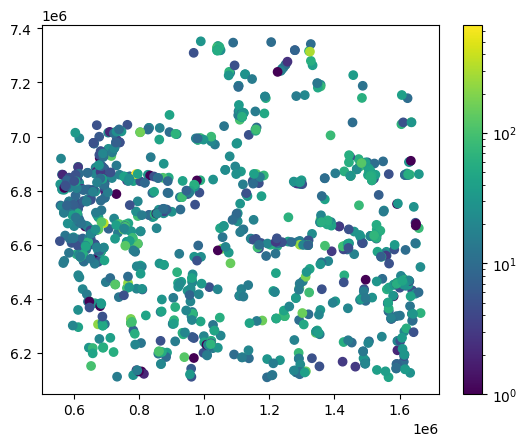

In [ ]:
plt.scatter(X[:,1], X[:,0], c=y, norm='log', label="Observations")
plt.colorbar()

In [ ]:
np.power((1,2),2)

array([1, 4])

# 3D using location and time when the spot was recorded (might use single ratings of spots here instead averaged)